In [1]:
# Problem 1
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random as rnd
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy

In [2]:
DELTA_T = 0.1

In [3]:
class MotionPlanner:

    def __init__(self, planner, K_v=1.0, eps=0.5, delta=0.05, plot=False):
        # Planning
        self.planner = planner
        self.x_idx, self.y_idx = self.planner.initial # map indices (in px)
        self.K_v = K_v # "controller" gain
        self.goal = np.array(self.planner.final)
        self.eps = eps      # goal error threshold [m]
        self.delta = delta  # heading error threshold [rad]
        
        # State
        initial = 0.1*np.array(self.planner.initial)
        self.state = np.array([[initial[0], initial[1], 0.]]).T
        self.gt = self.state.copy()
        self.state_prior = np.zeros_like(self.state)
        self.u = np.zeros((2, 1))

        # Params
        self.delta_t = DELTA_T
        self.l = 0.45
        self.plot = plot

        # Plotting
        self.history = []
        self.history.append(self.state.T)
        
        
    def cmd_vel(self, v, w):
        """
        Simulate velocity input:
            v: linear velocity
            w: angular velocity
        """
        self.u[0] = v
        self.u[1] = w
    
    
    def lin_vel_ctrl(self):
        """
        Linear velocity controller (P controller)
        """
        
        v = self.K_v * self.planner.net_force[self.y_idx][self.x_idx]
        # In case gradient is null
        if not v:
            v = 0.9
        return v
    
    
    def ang_vel_ctrl(self):
        """
        Angular velocity controller (P controller)
        """
        pass
   

    def ang_diff(self, theta1, theta2):
        """
        Returns the angular difference between the desired and current heading angle
        """
        return np.min((abs(theta1 - theta2), (2*np.pi - abs(theta1 - theta2))))


    def motion_model(self, state):
        new_state = np.zeros((3, 1))
        new_state[0, 0] = state[0, 0] + self.delta_t*self.u[0]*np.cos(state[2, 0])
        new_state[1, 0] = state[1, 0] + self.delta_t*self.u[0]*np.sin(state[2, 0])
        new_state[2, 0] = state[2, 0] + self.delta_t*self.u[1]
        new_state[2, 0] = (new_state[2, 0] + 2*np.pi)%(2*np.pi)
        return new_state

    
    def linearize_motion(self):
        # Jacobian G was determined analytically
        G = np.eye(3)
        G[0, 2] = -self.delta_t*self.u[0]*np.sin(self.state[2, 0])
        G[1, 2] = self.delta_t*self.u[0]*np.cos(self.state[2, 0])
        return G

    
    def measurement_model(self, state):
        # Assume measurements give
        meas = np.zeros((3, 1))
        meas[0, 0] = state[0, 0]
        meas[1, 0] = state[1, 0]
        meas[2, 0] = state[2, 0]
        return meas
        
    def linearize_meas(self):
        # Jacobian H was determined analytically
        H = np.eye(3)
        return H
    
    
    def close_enough(self):
        dist = np.sqrt((self.goal[0]-self.state[0, 0]/0.1)**2 + (self.goal[1]-self.state[1, 0]/0.1)**2)
        return  dist < self.eps
    
    
    def plot_path(self, data, title=""):
        """
        Plot robot position and orientation along path
        """
        fig = plt.figure(figsize=(36, 12))
        plt.imshow(planner.grid, cmap=plt.cm.gray_r)
        n = len(data)
        # Plot start and goal points
        plt.scatter(self.planner.initial[1], self.planner.initial[0], marker='s', color='black', s=100)
        plt.scatter(self.planner.final[1], self.planner.final[0], marker='s', color='black', s=100)
        
        # Plot path
        path = np.array(data)/0.1
        plt.scatter(path[:, 0, 1], path[:, 0, 0], c='c', s=20.25)
        plt.plot(path[:, 0, 1], path[:, 0, 0], c='c', label="path")
        plt.xlabel("X, [m]",fontsize=16)
        plt.ylabel("Y, [m]", fontsize=16)
        plt.title("XY", fontsize=16)
        plt.legend()
        
        
    # Run pose estimation
    def run(self, max_iter):
        print("Start: {}, Goal: {}".format(self.planner.initial, self.planner.final))
        iteration = 0
        while not self.close_enough() and iteration < max_iter: 
            
            # Approximate location of robot in grid world
            self.x_idx = np.rint(self.state[0, 0]/0.1).astype(np.int32)
            self.y_idx = np.rint(self.state[1, 0]/0.1).astype(np.int32)

            # Rotate in-place to match desired heading
            heading = self.planner.heading[self.x_idx][self.y_idx]
            if (iteration % 20) == 0:
                print("t: {} (x, y) - ({}, {})".format(iteration, self.y_idx, self.x_idx))
                print("State: {}".format(self.state.T))
                print("Heading: {}, Force: {}, Velocity: {}".format(heading, self.planner.net_force[self.y_idx][self.x_idx], self.u[0]))
            while self.ang_diff(heading, self.state[-1]) > self.delta:
                # Update velocity commands (constant turning angle)
                v = 0
                w = 0.5
                self.cmd_vel(v, w)
                # Motion update
                self.state = self.motion_model(self.state)
            
            # Simulate velocity update
            w = 0
            v = self.lin_vel_ctrl()
            self.cmd_vel(v, w)
            # Motion update
            self.state = self.motion_model(self.state)

            # Record state and measurement for plotting
            self.history.append(self.state.T)
            
            iteration += 1
        print("State: {}".format(self.state.T))
        if iteration == max_iter:
            print("Maximum iteration")
        else:
            print("Reached goal... exiting! (iter: {})".format(iteration))


In [4]:
class PathPlanner:

    def __init__(self, grid, start, goal, zeta_att, zeta_rep, plot=False):
        self.grid = grid
        self.obstacles = self.pre_process(deepcopy(grid))
        self.plot = plot
        self.map = None
        self.initial = start
        self.final = goal
        self.U = None
        self.V = None
        self.rep = None
        self.rep_grad = None
        self.pot = None
        self.net_force, self.heading = self.generate_path_plan(zeta_att, zeta_rep)
 

    def pre_process(self, grid):
        """
        Modify environment to meet planning constraints
        Returns the obstacles found in the environment
        """
        # Add 3px buffer space around obstacles to account for robot baseline (b/2 = 0.45m -> 5/2px -> 3px)
        buffer = 3
        dist = 1
        y_end, x_end = grid.shape
        for j in range(buffer):
            closest_y, closest_x = np.where(grid==1)
            num = closest_x.shape[0]
            for i in range(num):
                grid[max(closest_y[i]-1,0):min(closest_y[i]+2,y_end), max(closest_x[i]-1,0):min(closest_x[i]+2,x_end)] = np.where(grid[max(closest_y[i]-1,0):min(closest_y[i]+2,y_end), max(closest_x[i]-1,0):min(closest_x[i]+2,x_end)] == 0, 
                                                                                                                                  1,
                                                                                                                                  grid[max(closest_y[i]-1,0):min(closest_y[i]+2,y_end), max(closest_x[i]-1,0):min(closest_x[i]+2,x_end)])

        obstacles = np.argwhere(grid==1)
        return obstacles
    
    def generate_path_plan(self, zeta_att, zeta_rep):
        """
        Generate path plan for robot based on artificial potential fields method
        """
        # Combine attractive and repulsive potential fields
        att_pot, grad_att_pot = self.attractive_potential(self.grid.copy(), self.final, d_thres=2.0, zeta=zeta_att)
        rep_pot, grad_rep_pot = self.repulsive_potential(self.grid.copy(), zeta=zeta_rep)
        
        # Soften repulsive potential around goal to give more importance to attraction
        goal_x, goal_y = int(self.final[1]), int(self.final[0])
        xi = 0.9
        rep_pot[goal_x-5:goal_x+5, goal_y-5:goal_y+5] *= xi
        potential = att_pot + rep_pot
        self.pot = potential
        self.plot_grid(grid=att_pot, title="att_pot", mode=2)
        self.plot_grid(grid=rep_pot, title="rep_pot", mode=2)
        self.plot_grid(grid=potential, title="potential", mode=2)

        grad_y = np.gradient(potential, 1, axis=0)
        grad_x = np.gradient(potential, 1, axis=1)

        self.plot_grid(U=-grad_x, V=-grad_y, title="potential_gradient", mode=1)
        f_res = np.sqrt(grad_x**2 + grad_y**2)
        f_heading = np.arctan2(grad_x, grad_y) + np.pi
        return f_res, f_heading

    
    def attractive_potential(self, grid, goal=(95,95), d_thres=2.0, zeta=1.0):
        """
        Compute attractive potential function and gradient for path planning
            d_thres := threshold when potential switches from conic to parabolic approach
            zeta := attraction factor
        """
        bx, by = grid.shape
        g = np.array(goal)
        # Array of distances to goal
        d = np.array([np.sqrt((i - goal[1])**2 + (j - goal[0])**2) for j in range(by) for i in range(bx)]).reshape(bx, by)
        att_pot = np.zeros_like(grid)
        grad_att_pot = np.zeros((bx, by, 2)) # array of 2D gradients
        for j in range(by):
            for i in range(bx):
                if d[j][i] <= d_thres: # conic approach
                    att_pot[j][i] = 0.5*zeta*d[j][i]**2
                    grad_att_pot[j][i] = zeta * (np.array((j,i)) - g)
                    # grad_att_pot[i][j] = zeta * d[i][j]
                else: # parabolic approach
                    att_pot[j][i] = d_thres*zeta*d[j][i] - 0.5*zeta*d_thres**2
                    grad_att_pot[j][i] = d_thres * zeta * (np.array((j,i)) - g) / d[j][i]

        return att_pot, grad_att_pot

    
    def brushfire(self, grid, x_end, y_end):
        """
        Repulsive potential approximation using the Brushfire algorithm
        """
        dist = 1
        while not np.all(grid):
            closest_y, closest_x = np.where(grid==dist)
            num = closest_x.shape[0]
            for i in range(num):
                grid[max(closest_y[i]-1,0):min(closest_y[i]+2,y_end), max(closest_x[i]-1,0):min(closest_x[i]+2,x_end)] = np.where(grid[max(closest_y[i]-1,0):min(closest_y[i]+2,y_end), max(closest_x[i]-1,0):min(closest_x[i]+2,x_end)] == 0, 
                                                                                                                                  dist+1,
                                                                                                                                  grid[max(closest_y[i]-1,0):min(closest_y[i]+2,y_end), max(closest_x[i]-1,0):min(closest_x[i]+2,x_end)])
            dist += 1

            
    def repulsive_potential(self, grid, zeta=1.0, eight_connectivity=False):
        """
        Approximates the repulsive potential function and its gradient
        """
        # Map should be "binary": e.g. 0 - 1, 0 - 255
        if np.unique(grid).size != 2:
            print("Invalid grid map")
        
        # Assumption: lower value denotes free configuration space; higher value denotes obstacle
        min_val, max_val = np.min(grid), np.max(grid)
        if min_val != 0:
            grid = grid / min_val
        
        if max_val != 1:
            grid = grid / max_val

        assert(np.min(grid) == 0)
        assert(np.max(grid) == 1)
        
        by, bx = grid.shape
        # NOTE: Since brushfire starts from the obstacles (grid=1), it will actually create "mounts" where free space lies
        # Instead, we want to produce "mounts" for obstacles and "gulleys" for free space
        # We can easily invert this relationship through transformation
        self.brushfire(grid, bx, by)
        grid -= np.max(grid)
        grid *= -1

        # Approximate positive gradient (i.e. repulsion) by finding neighbor with highest value
        grad_rep_pot = np.zeros((bx, by, 2)) # array of 2D gradients
        for j in range(by):
            for i in range(bx):
                window = grid[max(j-1,0):min(j+2,by), max(i-1,0):min(i+2,bx)]
                max_neigh = np.unravel_index(np.argmin(window, axis=None), window.shape)
                grad_rep_pot[j][i] = np.array(max_neigh) - np.array((1, 1))
        return zeta*grid, grad_rep_pot
  

    def plot_grid(self, grid=None, U=None, V=None, title="title", mode=0):
        """
        Helper function to plot various grids
        """
        if self.plot:
            fig = plt.figure(figsize=(36, 12))
            if mode == 0:
                plt.imshow(grid)
                plt.colorbar()
#                 plt.savefig(title + ".png", dpi=200)
            elif mode == 1:
                quiv, ax1  = plt.subplots()
                ax1.quiver(U, V)
                ax1.set_xlabel('X')
                ax1.set_ylabel('Y')
#                 plt.savefig(title + ".png", dpi=200)
            elif mode == 2:
                surf = plt.figure()
                X, Y = np.meshgrid(np.arange(0, grid.shape[0], 1), np.arange(0, grid.shape[1], 1))
                ax = surf.gca(projection='3d')
                ax.plot_surface(X, Y, grid, alpha=0.8)

                ax.set_xlabel('x')
                ax.set_ylabel('y')
                ax.set_zlabel('U')
#                 plt.savefig(title + ".png", spi=200)
            else:
                print("Plotting mode not recognized!")

            plt.title(title)


In [5]:
# Utils
def read_pgm(pgmf):
    """
    Read pgm map as numpy array
    """
    with open( pgmf, 'rb' ) as f:
        #Return a raster of integers from a PGM as a list of lists
        header =  f.readline()
        # print( header[0], header[1] )
        assert header == b'P5\n'
        while True:
            l = f.readline()
            if not l[0] == 35:   # skip any header comment lines
                break
        (width, height) = [int(i) for i in l.split()]
        depth = int(f.readline())
        assert depth <= 255

        raster = []
        for y in range(height):
            row = []
            for y in range(width):
                row.append(ord(f.read(1)))
            raster.append(row)
    return np.array(raster)

Start: (5.0, 5.0), Goal: (95.0, 95.0)
t: 0 (x, y) - (5, 5)
State: [[0.5 0.5 0. ]]
Heading: 0.7853981633974483, Force: 5.656854249492381, Velocity: [0.]
t: 20 (x, y) - (14, 23)
State: [[2.27972967 1.3566317  6.06725877]]
Heading: 6.085789747329706, Force: 2.5495097567963922, Velocity: [0.80777472]
t: 40 (x, y) - (14, 34)
State: [[3.40926236 1.35213735 6.23451754]]
Heading: 6.283185307179586, Force: 2.0, Velocity: [0.6]
t: 60 (x, y) - (14, 56)
State: [[5.64135979 1.42825157 6.25177631]]
Heading: 6.283185307179586, Force: 5.408326913195984, Velocity: [1.62249807]
t: 80 (x, y) - (15, 71)
State: [[7.10042973 1.45761446 6.26859101]]
Heading: 6.283185307179586, Force: 1.0, Velocity: [0.3]
t: 100 (x, y) - (16, 76)
State: [[7.60099287 1.59509117 0.75222039]]
Heading: 0.7853981633974483, Force: 0.7071067811865476, Velocity: [0.21213203]
t: 120 (x, y) - (19, 80)
State: [[7.96998796 1.86829287 0.73584978]]
Heading: 0.7853981633974483, Force: 0.7071067811865476, Velocity: [0.21213203]
t: 140 (x, y)

<Figure size 2592x864 with 0 Axes>

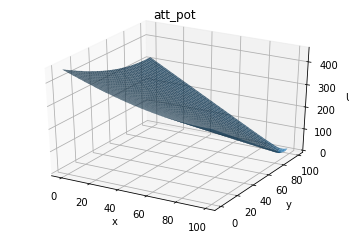

<Figure size 2592x864 with 0 Axes>

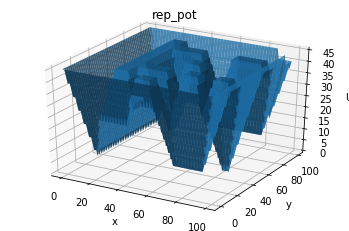

<Figure size 2592x864 with 0 Axes>

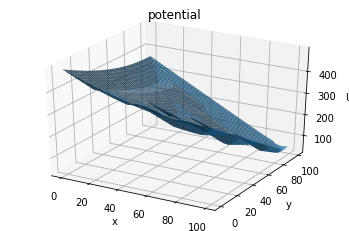

<Figure size 2592x864 with 0 Axes>

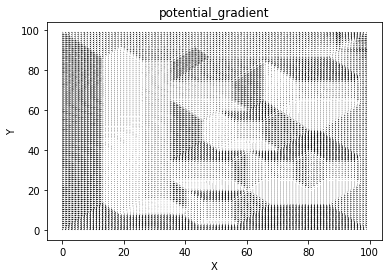

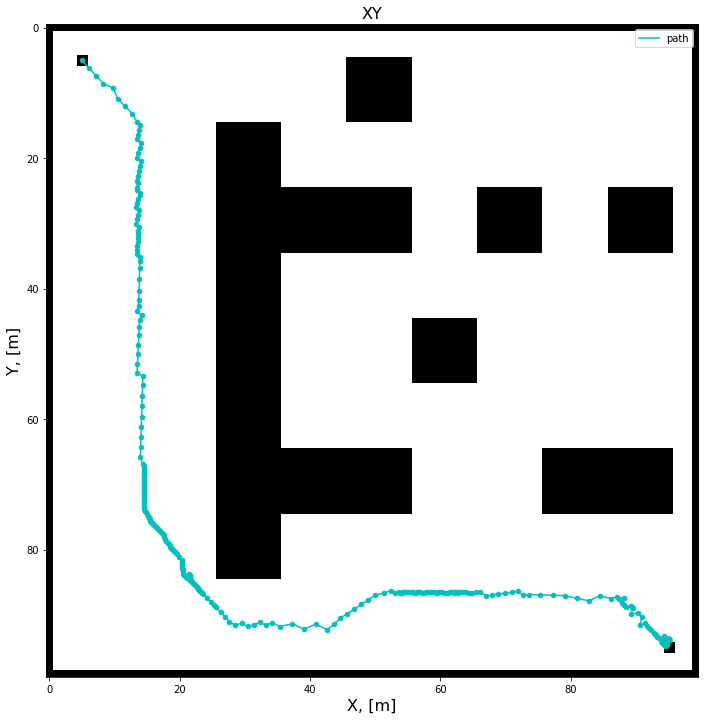

In [6]:
if __name__ == '__main__':
    DURATION = 500
    try:
        # Read pgm map file
        grid = read_pgm('sim_map.pgm')
        grid = np.where(grid==255, 0, 1)
        
        # Path planning
        start = (5.,5.) # (Y, X)
        goal = (95., 95.) # (Y, X)
        planner = PathPlanner(grid, start, goal, zeta_att=1.7, zeta_rep=3.0, plot=True)

        # Motion planning
        motion_planner = MotionPlanner(planner, K_v=0.3, plot=True)
        motion_planner.run(max_iter=DURATION)
        motion_planner.plot_path(motion_planner.history, title="path")

    except KeyboardInterrupt:
        exit(0)

In [7]:
# END